In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

In [2]:
class AsianOption:
    
    def __init__(self, m, r, S0, K, sigma, T):
        """
        
        :param m: int; number of stock price path
        :param r: float; risk neutral interest rate
        :param S0: float; current stock price
        :param K: float; strike price at expiration
        :param T: float; expiration time (year)
        :param num_paths: int; number of stock price paths
        :return: price of Asian Option using regular monte carlo simulation
        """
        # parameter initialization
        self.m = m
        self.r = r
        self.S0 = S0
        self.K = K
        self.sigma = sigma
        self.T = T
        
        # asian option price using analytical formula
        T_bar = 0.5 * (m + 1) * T / m
        sigma_bar = sigma * np.sqrt((2 * m + 1) / (3 * m))
        delta = (1 / 6) * sigma ** 2 * (m - 1) / m
        d = (np.log(S0 / K) + (r - delta + 0.5 * sigma_bar ** 2) * T_bar) / (sigma_bar * np.sqrt(T_bar))
        self.analytical_geom_price = np.exp(-delta * T_bar - r * (T - T_bar)) * S0 * stats.norm.cdf(d) - \
                K * np.exp(-r * T) * stats.norm.cdf(d - sigma_bar * np.sqrt(T_bar))
        
    def monte_carlo(self, num_paths, alpha=0.05):
        """
        asian option pricing using regular monte carlo method and control variate method
        :param num_paths: int; number of paths for stock prices
        :return : 
        """
        # generate standard normal variables
        Z = np.random.normal(0, 1, size=(num_paths, self.m))

        # calculate paths for stock prices
        stock_prices = self.S0 * np.exp(np.cumsum((self.r - 0.5 * self.sigma ** 2) * self.T / self.m + 
                                        self.sigma * np.sqrt(self.T / self.m) * Z, axis=1))
        
        # price of asian options with arithmatic and geometric payoff
        arith_paths = np.exp(-self.r * self.T) * np.maximum(stock_prices.mean(axis=1) - self.K, 0)
        geom_paths = np.exp(-self.r * self.T) * np.maximum(stats.gmean(stock_prices, axis=1) - self.K, 0)
        
        # covariance of geometric and arithmetic average price
        cov_matrix = np.cov(arith_paths, geom_paths, bias=False)
        
        # regular monte carlo method
        arith_price = np.mean(arith_paths)
        arith_std = cov_matrix[0][0]**0.5
        arith_sse = stats.norm.ppf(1 - alpha / 2) * arith_std / np.sqrt(num_paths)
        
        # control variate method
        geom_std = cov_matrix[1][1]**0.5
        corr_rho = cov_matrix[0][1] / (arith_std * geom_std)  # correlation coefficient for speedup
        speedup_factor = 1 / (1 - corr_rho ** 2)
        b_star = corr_rho * arith_std / geom_std
        covar_paths = arith_paths - b_star * (geom_paths - self.analytical_geom_price)
        covar_price = np.mean(covar_paths)
        covar_std = np.std(covar_paths)
        covar_sse = stats.norm.ppf(1 - alpha / 2) * covar_std / np.sqrt(num_paths)
        
        return arith_price, arith_price + arith_sse, arith_price - arith_sse, \
                covar_price, covar_price + covar_sse, covar_price - covar_sse, corr_rho, speedup_factor
    

In [6]:
# instantize the AsianOption class
asian_option = AsianOption(r=0.01, sigma=0.3, K=100, S0=110, T=1, m=12)
print(f"analytical geometric price from BSFormula: {asian_option.analytical_geom_price}.")

analytical geometric price from BSFormula: 13.405754003897925.


In [4]:
summary = pd.DataFrame({trial: asian_option.monte_carlo(trial) for trial in np.power(10, [3, 4, 5, 6])}).T
summary.columns = ["point_estimator_regular_mc", "upper_bound_regular_mc", "lower_bound_regular_mc", 
                  "point_estimator_control_variate", "upper_bound_control_variate", "lower_bound_control_variate", 
                  "correlation_coefficient", "variate_reduction_factor"]
summary

,point_estimator_regular_mc,upper_bound_regular_mc,lower_bound_regular_mc,point_estimator_control_variate,upper_bound_control_variate,lower_bound_control_variate,correlation_coefficient,variate_reduction_factor
1000,14.266324,15.289494,13.243153,13.930081,13.961570,13.898591,0.999526,1054.720468
10000,13.908704,14.232503,13.584905,13.951931,13.963340,13.940521,0.999379,805.313331
100000,14.031630,14.134833,13.928427,13.953729,13.957407,13.950051,0.999365,787.365119
1000000,13.957862,13.990378,13.925347,13.950690,13.951849,13.949531,0.999365,787.167537


### From the last two columns of the table above we can see that the larger the correlation coefficient the higher the speed-up effectiveness.

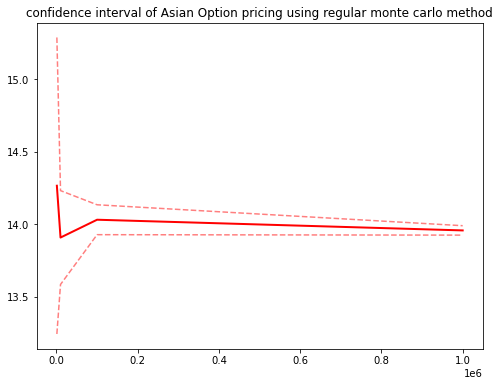

<Figure size 432x288 with 0 Axes>

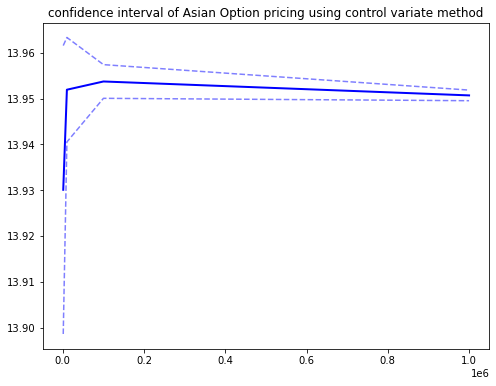

In [5]:
plt.figure(figsize=(8, 6))
plt.plot(summary["point_estimator_regular_mc"], color="r", linewidth=2)
plt.plot(summary["upper_bound_regular_mc"], color="r", linestyle="--", alpha=0.5)
plt.plot(summary["lower_bound_regular_mc"], color="r", linestyle="--", alpha=0.5)
plt.title("confidence interval of Asian Option pricing using regular monte carlo method")
plt.show()
plt.clf()
plt.figure(figsize=(8, 6))
plt.plot(summary["point_estimator_control_variate"], color="blue", linewidth=2)
plt.plot(summary["upper_bound_control_variate"], color="blue", linestyle="--", alpha=0.5)
plt.plot(summary["lower_bound_control_variate"], color="blue", linestyle="--", alpha=0.5)
plt.title("confidence interval of Asian Option pricing using control variate method")
plt.show()

### From the above two figures we can see that by using control variate method the point estimation is much more precise at the beginning with fewer trials.   
### Besides, the standard error of estimation or the confidence interval is significantly lower than the one using regular monte carlo method.